# Dialect regions from image
 
Use image processing to extract longitude-latitude polygons for four dialect regions illustrated in this image.

![dialect regions](../data/dialects.png)

In [1]:
import sys
sys.path.append('..')

import folium
import json

from collections import Counter

from math import sqrt, floor
import numpy as np
from imageio import imread

%matplotlib notebook
from matplotlib import pyplot as plt

from skimage.morphology import binary_closing
from skimage.measure import find_contours, label

import folium.plugins
from folium_jsbutton import JsButton

from stimmen.latitude_longitude import reverse_latitude_longitude

## Input

In [2]:
im = imread('../data/dialects.png')
regions =  ['Klaaifrysk', 'Waldfrysk', 'Sudwesthoeksk', 'Noardhoeksk']

color_occurence = Counter(map(tuple, im.reshape(-1,3)))
colors_sorted_by_occurence = [c for c, _ in sorted(
    color_occurence.items(),
    key=lambda x: x[1],
    reverse=True)
]

## Figure out relevant colors

<IPython.core.display.Javascript object>


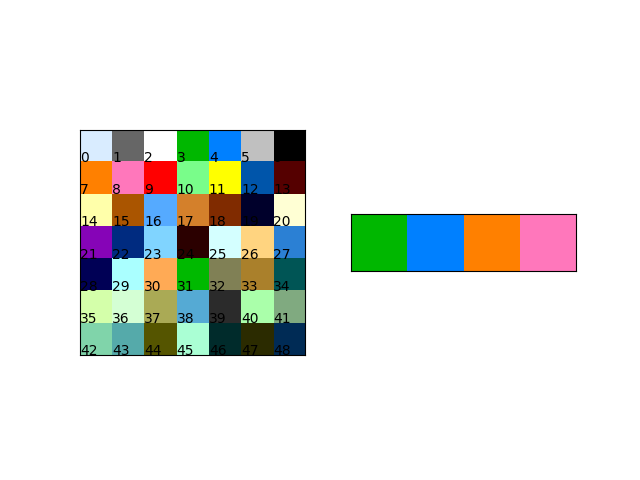

In [3]:
pallette_width = floor(sqrt(len(colors_sorted_by_occurence)))
pallette = np.array(colors_sorted_by_occurence[:pallette_width**2]).reshape(pallette_width, pallette_width, 3)

_, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(pallette)
for x in range(pallette_width):
    for y in range(pallette_width):
        ax0.text(x-0.5, y+0.5, str(x + y * pallette_width))
ax0.set_xticks([]), ax0.set_yticks([])



pallette_indices = [3, 4, 7, 8]
pallette = [colors_sorted_by_occurence[i] for i in pallette_indices]
pallette = np.array(pallette).reshape(1, -1, 3)
ax1.imshow(pallette)
ax1.set_xticks([]), ax1.set_yticks([])
None

## Georeference image

In [4]:
bounds = [
    [ 53.54634089638824, 6.530699920654293],
    [52.60043228879454, 4.684483127594012 ]
]

m = folium.Map(
    location=[(bounds[0][0] + bounds[1][0]) / 2, (bounds[0][1] + bounds[1][1]) / 2],
    tiles='stamentoner',
    zoom_start=9
)

overlay = folium.raster_layers.ImageOverlay(
    image='../data/dialects.png',
    bounds=bounds,
    opacity=0.5
).add_to(m)

overlay_id = overlay._id

for number, (corner, direction, operation) in enumerate(
    (c, d, o)
    for c in ['_northEast', '_southWest'] for d in ['lat', 'lng'] for o in ['-', '+']
):
    JsButton(title=str(number), function="""function(map, item) {{
        var overlay = image_overlay_{overlay_id};
        var bounds = overlay.getBounds()
        bounds.{corner}.{direction} {operation}= 0.001;
        overlay.setBounds(bounds);
        
}}""".format(overlay_id=overlay_id, corner=corner, direction=direction, operation=operation)).add_to(m)


JsButton(title='B', function="""function(map, item) {{
        var overlay = image_overlay_{overlay_id};
        var bounds = overlay.getBounds()
        console.log([bounds._northEast.lat, bounds._northEast.lng, bounds._southWest.lat, bounds._southWest.lng])
        
}}""".format(overlay_id=overlay_id)).add_to(m)
    
m

## Find polygons in pixelcoordinates

<IPython.core.display.Javascript object>


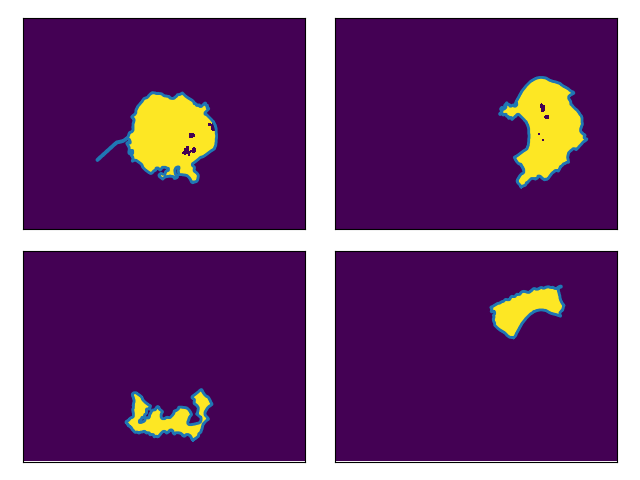

In [5]:
axes = plt.subplots(2,2)[1].ravel()
contours = []
for axis, c in zip(axes, pallette[0]):
    bi = (im[:-100] == c[None,None]).min(axis=2)
    bi = binary_closing(bi, np.ones((5,5)))
    
    labels = label(bi, background=False)
    
    contours.append(find_contours(bi, 0.5))

    axis.imshow(bi)
    for n, contour in enumerate(contours[-1][:1]):
        axis.plot(contour[:, 1], contour[:, 0], linewidth=2)
        axis.set_xticks([]); axis.set_yticks([])
plt.tight_layout()

## Convert to longitude-latitudes and write geojson

In [6]:
(y0, x1), (y1, x0) = bounds

scale_x = lambda x: ((x / im.shape[1]) * (x1 - x0) + x0).tolist()
scale_y = lambda y: ((y / im.shape[0]) * (y1 - y0) + y0).tolist()

contours_scaled = [
    list(zip(scale_x(c[0][:, 1]), scale_y(c[0][:, 0])))
    for c in contours
]

In [9]:
geojson = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {'dialect': dialect},
      "geometry": {
        "type": "Polygon",
        "coordinates": [list(map(list, contour))]
      }
    }
    for contour, dialect in zip(contours_scaled, regions)
  ]
}

with open('../data/fryslan_dialect_regions.geojson', 'w') as f:
    json.dump(geojson, f)

## Result

In [8]:
m = folium.Map(
    location=[(bounds[0][0] + bounds[1][0]) / 2, (bounds[0][1] + bounds[1][1]) / 2],
    tiles='stamentoner',
    zoom_start=9
)

for feature in geojson['features']:
    folium.Polygon(
        reverse_latitude_longitude(feature['geometry']['coordinates']),
        color='red',
        fill_color='white',
        fill_opacity=0,
        popup=feature['properties']['dialect']
    ).add_to(m)

m